In [2]:
import json
import os
import random
import re

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from alive_progress import alive_bar
from sentence_transformers import SentenceTransformer, util

from language_classifier.language_classifier import LanguageClassifier

# formatting
pd.set_option('display.float_format', '{:.1f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# import data

In [3]:
# folders
parsed_docs_folder = os.path.join("..", "ParsedPublications")
fr_eng_correlation_csv = "fr_eng_correlation_data.csv"

fr_eng_correlation_df = pd.read_csv(fr_eng_correlation_csv)

# weblinks for previewing / testing
weblinks_df = fr_eng_correlation_df.copy()
weblinks_df = weblinks_df[['pub_number', 'nom', 'name', 'url_fr', 'url_en', 'file_url_fr', 'file_url_en']]

# simplified correlation table
fr_eng_correlation_df = fr_eng_correlation_df[['pub_number', 'filename_fr', 'filename_en']]

# helper functions

In [63]:
# DATA CLEANING FUNCTIONS

def clean_text(text, skip=False):
    if not skip:
        allowed_chars = r"[^a-zA-ZÀ-ÖØ-öø-ÿ0-9.,;:!?()'\"-]"
        text = re.sub(allowed_chars, ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()

    return text


def get_files_for_publication(pub_number, fr_eng_correlation_df):
    row = fr_eng_correlation_df.loc[fr_eng_correlation_df['pub_number'] == pub_number]
    if not row.empty:
        filename_fr = row['filename_fr'].values[0]
        filename_en = row['filename_en'].values[0]
        return filename_fr, filename_en
    return None, None


def get_json_file_link(parsed_docs_folder, pdf_filename):
    if pdf_filename.endswith(".pdf"):
        json_filename = pdf_filename + ".json"
        for root, _, files in os.walk(parsed_docs_folder):
            if json_filename in files:
                return os.path.join(root, json_filename)
    return None


def extract_text_from_single_file(json_file, target_language, clf, skip_cleaning=False):
    min_block_length = 10
    max_block_length = 500
    
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'text' not in data:
        raise KeyError(f"The key 'text' is missing in the JSON file: {json_file}")
    
    full_text = clean_text(data['text'], skip_cleaning)
    text_blocks = re.split(r'(?<![;,])[.?!]\s|\n\n', full_text)
    text = []

    for block in text_blocks:
        block = block.strip()
        if len(block) < min_block_length or len(block) > max_block_length:
            continue
        
        if clf.classify(block) == target_language:
            text.append(block + '. ')      

    return " ".join(text)


def extract_both_languages_from_two_files(json_file_fr, json_file_en, clf, skip_cleaning=False):
    return extract_text_from_single_file(json_file_fr, "fr", clf, skip_cleaning), extract_text_from_single_file(json_file_en, "en", clf, skip_cleaning)


def extract_both_languages_from_single_file(json_file, clf, skip_cleaning=False):
    min_block_length = 10
    max_block_length = 500
    
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'text' not in data:
        raise KeyError(f"The key 'text' is missing in the JSON file: {json_file}")
    
    full_text = clean_text(data['text'], skip_cleaning)
    text_blocks = re.split(r'(?<![;,])[.?!]\s|\n\n', full_text)
    text_fr, text_en = [], []

    for block in text_blocks:
        block = block.strip()
        if len(block) < min_block_length or len(block) > max_block_length:
            continue
            
        if clf.classify(block) == "fr":
            text_fr.append(block + '. ')   
        elif clf.classify(block) == "en":
            text_en.append(block + '. ')   

    return " ".join(text_fr), " ".join(text_en)


def create_sentences(text_fr, text_en):
    sentences_fr = [x.strip() for x in re.split(r'(?<![;,])[.?!]\s|\n\n', text_fr) if x != ""]
    sentences_en = [x.strip() for x in re.split(r'(?<![;,])[.?!]\s|\n\n', text_en) if x != ""]
    
    return sentences_fr, sentences_en


def create_similarity_matrix(sentences_fr, sentences_en, sentence_encoder):
    embeddings_fr = sentence_encoder.encode(sentences_fr, convert_to_tensor=True)
    embeddings_en = sentence_encoder.encode(sentences_en, convert_to_tensor=True)

    return util.pytorch_cos_sim(embeddings_fr, embeddings_en)


# TODO: process_all_rows replaced with debug version (below) for this analysis


def text_from_coordinates(aligned_pairs, sentences_fr, sentences_en, pub_number):
    correlated_list = list()
    for i, j in aligned_pairs:
        correlated_list.append((pub_number, sentences_fr[i], sentences_en[j]))
    
    return correlated_list


def correlate_and_clean_text(text_fr, text_en, pub_number, sentence_encoder):
    sentences_fr, sentences_en = create_sentences(text_fr, text_en)
    similarity_matrix = create_similarity_matrix(sentences_fr, sentences_en, sentence_encoder)
    _, _, aligned_pairs = align_sentences(similarity_matrix)  # TODO: updated for EDA

    return text_from_coordinates(aligned_pairs, sentences_fr, sentences_en, pub_number)


# TODO: process_all_rows replaced with debug version (below) for this analysis


# PREVIEW AND DEBUGGING

def preview_publication(pub_number):
    if type(pub_number) is pd.DataFrame and pub_number.shape[0] == 1:
        try:
            pub_number = pub_number['pub_number'].values[0]
        except ValueError:
            return None
    elif type(pub_number) is pd.Series:
        try:
            pub_number = pub_number.values[0]
        except ValueError:
            return None
    
    try:
        output_df = weblinks_df[weblinks_df.pub_number == pub_number].T
    except Exception as e:
        print(e)
        return None
        
    display(output_df)


def preview_publication_by_row(row_n):
    display(pd.DataFrame(matched_df.iloc[row_n]))
    preview_publication(matched_df.iloc[row_n].pub_number)
    
    
def plot_similarity_heatmap(similarity_matrix, figsize=(10, 10), low_similarity=0.6, high_similarity=0.8, matched_pairs=None, cmap=None, norm=None, square=True):
    fig, ax = plt.subplots(figsize=figsize) 
    
    if cmap:
        if norm:
            sns.heatmap(similarity_matrix, cmap=cmap, norm=norm, cbar=False, square=square, linewidths=0, ax=ax)
        else:
            sns.heatmap(similarity_matrix, cmap=cmap, cbar=False, square=square, linewidths=0, ax=ax)
    else:
        cmap = mcolors.ListedColormap(["black", "darkblue", "deepskyblue"])
        bounds = [0, low_similarity, high_similarity, 1]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
        sns.heatmap(similarity_matrix, cmap=cmap, norm=norm, cbar=False, square=square, linewidths=0, ax=ax)

    if matched_pairs:
        x_coords, y_coords = zip(*matched_pairs)
        ax.plot(x_coords, y_coords, marker='o', linestyle='-', color='red', markersize=4, linewidth=1.5)

    ax.tick_params(left=False, bottom=False)

    plt.tight_layout()
    plt.show()
    

def display_similarity_matrix(similarity_matrix, inverse=False, figsize=(10, 10)):
    if inverse:
        plot_similarity_heatmap(similarity_matrix.T, figsize=figsize)
    else:
        plot_similarity_heatmap(similarity_matrix, figsize=figsize)


def text_from_row(row_n):
    return matched_df.iloc[row_n]['text_fr'], matched_df.iloc[row_n]['text_en']


def text_from_pub_number(pub_number):
    return matched_df[matched_df.pub_number == pub_number].text_fr.values[0], matched_df[matched_df.pub_number == pub_number].text_en.values[0]



# TODO: ALTERNATE VERSION OF ALIGN SENTENCE FOR EDA
def align_sentences(sim_matrix, threshold=0.7):
    n, m = sim_matrix.shape

    weights = np.where(sim_matrix >= threshold, sim_matrix, 0.0)

    dp = np.zeros((n+1, m+1), dtype=np.float32)

    for i in range(1, n+1):
        for j in range(1, m+1):
            score_match = dp[i-1, j-1] + weights[i-1, j-1]
            score_skip_fr = dp[i-1, j]
            score_skip_en = dp[i, j-1]

            dp[i, j] = max(score_match, score_skip_fr, score_skip_en)

    aligned_pairs = []
    i, j = n, m
    while i > 0 and j > 0:
        current_val = dp[i, j]
        if np.isclose(current_val, dp[i-1, j]):
            i -= 1
        elif np.isclose(current_val, dp[i, j-1]):
            j -= 1
        else:
            if weights[i-1, j-1] > 0:
                aligned_pairs.append((i-1, j-1))
            i -= 1
            j -= 1

    aligned_pairs.reverse()
    return dp, dp[n, m], aligned_pairs


# TODO: ALTERNATE VERSION OF PROCESS ALL ROWS FOR EDA
def process_all_rows_debug(fr_eng_correlation_df, parsed_docs_folder, clf):
    matched_data = []

    for _, row in fr_eng_correlation_df.iterrows():
        pub_number = row['pub_number']
        filename_fr, filename_en = row['filename_fr'], row['filename_en']

        if filename_fr == "WITHDRAWN" and filename_en == "WITHDRAWN":
            continue

        fr_link = get_json_file_link(parsed_docs_folder, filename_fr)
        if fr_link == None:
            continue

        if filename_fr == filename_en:
            text_fr, text_en = extract_both_languages_from_single_file(fr_link, clf, True)  # TODO: confirm skipping cleaning until final step
        else:
            en_link = get_json_file_link(parsed_docs_folder, filename_en) 
            if en_link == None:
                continue
            text_fr, text_en = extract_both_languages_from_two_files(fr_link, en_link, clf, True)  # TODO: confirm skipping cleaning until final step

        matched_data.append({'pub_number': pub_number, 'text_fr': text_fr, 'text_en': text_en})

    return pd.DataFrame(matched_data)

# EDA

### confirm clean text vs skip (skipping looks better, clean after correlating)

In [5]:
sentence_encoder = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
language_classifier = LanguageClassifier()

In [6]:
# test 'RES 2020/050' with and without text cleaning
get_files_for_publication('RES 2020/050', fr_eng_correlation_df)

('40930889.pdf', '40930828.pdf')

In [7]:
json_file_fr, json_file_en = (get_files_for_publication('RES 2020/050', fr_eng_correlation_df)[0], 
                              get_files_for_publication('RES 2020/050', fr_eng_correlation_df)[1])

skipped_text = extract_both_languages_from_two_files(
    get_json_file_link(parsed_docs_folder, json_file_fr), 
    get_json_file_link(parsed_docs_folder, json_file_en), 
    language_classifier,
    skip_cleaning=True
)

unskipped_text = extract_both_languages_from_two_files(
    get_json_file_link(parsed_docs_folder, json_file_fr), 
    get_json_file_link(parsed_docs_folder, json_file_en), 
    language_classifier,
    skip_cleaning=False
)

In [8]:
# cleaning before splitting into blocks affects classification
len(clean_text(skipped_text[0])), len(unskipped_text[0])

(148680, 141403)

In [9]:
for sentence in unskipped_text[1][:500].split('. '):
    print(sentence)

Canadian Science Advisory Secretariat (CSAS) Research Document National Capital Region September Approaches for Assessing and Monitoring Representation, Replication, and Connectivity in Marine Conservation Networks Arieanna C
 As such, it addresses the issues of the day in the time frames required and the documents it contains are not intended as definitive statements on the subjects addressed but rather as progress reports on ongoing investigations
 Published by: Fisheries and Oceans Canada C


In [10]:
for sentence in skipped_text[1][:500].split('. '):
    print(clean_text(sentence))

Canadian Science Advisory Secretariat (CSAS)
Research Document National Capital Region
Approaches for Assessing and Monitoring Representation, Replication, and Connectivity in Marine Conservation Networks
Department of Oceanography Dalhousie University Oxford Street
Québec, QC G V A Comox Valley Project Watershed Society
Pacific Regional Headquarters Fisheries and Oceans Canada
PO Box Sidney, BC V L B
Foreword This series documents the scientifi


### redo EDA without text cleaning

In [11]:
matched_df = process_all_rows_debug(fr_eng_correlation_df, parsed_docs_folder, language_classifier)
matched_df['len_fr'] = matched_df['text_fr'].str.len()
matched_df['len_en'] = matched_df['text_en'].str.len()
matched_df['len_diff'] = np.where(
    matched_df[['len_fr', 'len_en']].min(axis=1) == 0,
    999,
    matched_df[['len_fr', 'len_en']].max(axis=1) / matched_df[['len_fr', 'len_en']].min(axis=1)
)
matched_df['len_min'] = matched_df[['len_fr', 'len_en']].min(axis=1)
matched_df = pd.merge(matched_df, fr_eng_correlation_df, on='pub_number')

In [12]:
row_n = 1000
sentences_fr, sentences_en = create_sentences(matched_df.iloc[row_n]['text_fr'], matched_df.iloc[row_n]['text_en'])
similarity_matrix = create_similarity_matrix(sentences_fr, sentences_en, sentence_encoder)

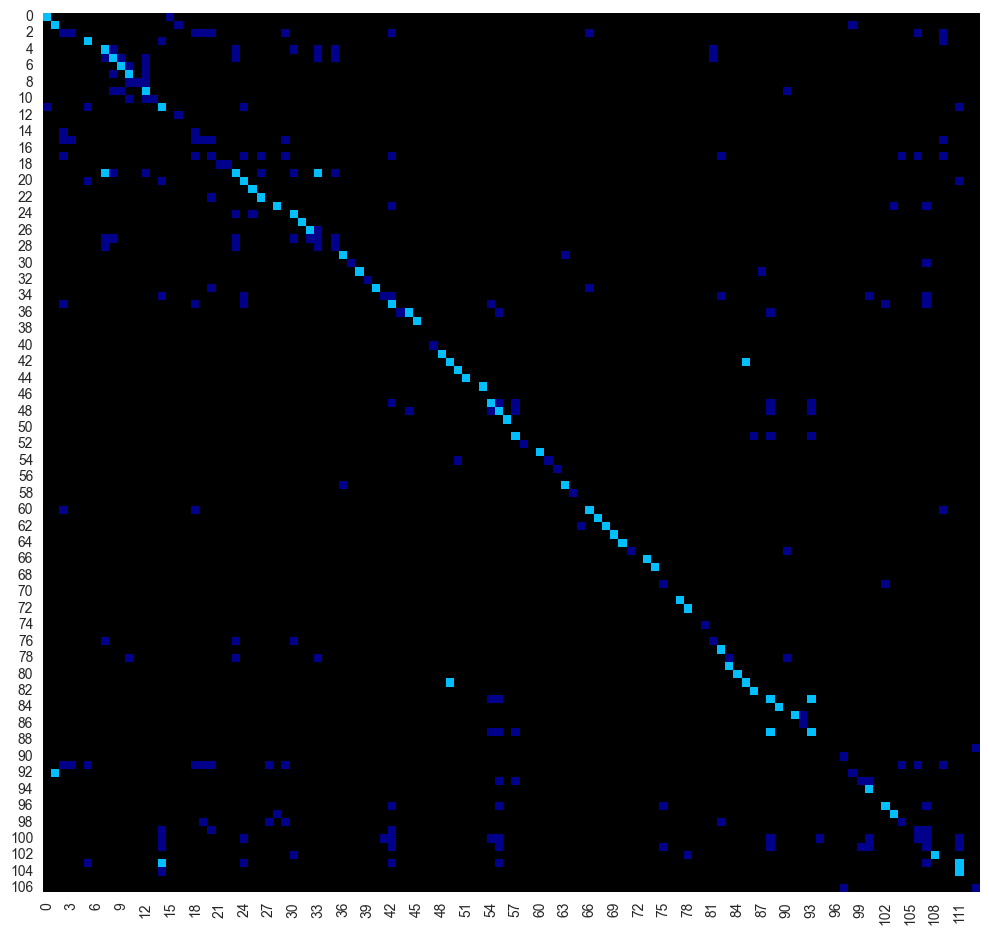

In [13]:
display_similarity_matrix(similarity_matrix)

### previous similarity matrix, including text cleaning prior to classification and correlation:
![](images/similarity_matrix_row_1000.png)

# Junk Data (abstract only translations)

In [14]:
# let's look at the garbage data and see if we can fix it
min_doc_length = 1000
matched_df[((matched_df.len_fr < min_doc_length) | (matched_df.len_en < min_doc_length))].drop(['text_fr', 'text_en'], axis=1).sample(10)

,pub_number,len_fr,len_en,len_diff,len_min,filename_fr,filename_en
2268,RES 1989/061,755,6937,9.2,755,179848.pdf,179848.pdf
140,PRO 2000/024,87,31113,357.6,87,317109.pdf,317109.pdf
1524,RES 1981/054,231,5072,22.0,231,280.pdf,280.pdf
1286,RES 1977/021,0,15613,999.0,0,75605.pdf,75605.pdf
1565,RES 1982/012,561,27418,48.9,561,29162.pdf,29162.pdf
8550,SSR 1999/D6-09,59,11131,188.7,59,318397.pdf,318397.pdf
1690,RES 1983/084,651,6470,9.9,651,21537.pdf,21537.pdf
8743,SSR 2001/C6-17,60,12825,213.8,60,40647092.pdf,40647092.pdf
1340,RES 1978/045,128,16737,130.8,128,75671.pdf,75671.pdf
1472,RES 1980/082,354,3744,10.6,354,79522.pdf,79522.pdf


In [15]:
matched_df.iloc[4000, 3:]

len_fr               4205
len_en              80713
len_diff             19.2
len_min              4205
filename_fr    272802.pdf
filename_en    272802.pdf
Name: 4000, dtype: object

In [16]:
n = 4000
# display_similarity_matrix(n)
text_fr, text_en = matched_df.iloc[n, 1], matched_df.iloc[n, 2]
# create_similarity_matrix(text_fr, text_en)
preview_publication_by_row(n)

,4000
pub_number,RES 2002/123
text_fr,S C C S\nSecrétariat canadien de consultation scientifique. Ne pas citer sans\nautorisation des...
text_en,C S A S\nCanadian Science Advisory Secretariat. Not to be cited without\npermission of the auth...
len_fr,4205
len_en,80713
len_diff,19.2
len_min,4205
filename_fr,272802.pdf
filename_en,272802.pdf


,4053
pub_number,RES 2002/123
nom,Examen de la biologie et de la pêche des Embiotocidés de la Colombie-Britannique.
name,A review of the biology and fishery of the Embiotocids of British Columbia.
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2002/2002_123-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2002/2002_123-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/272802.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/272802.pdf


In [17]:
diff_max = 5
matched_df[matched_df.len_diff > diff_max].shape[0]

4923

In [18]:
matched_df['len_diff'].describe()

count   8936.0
mean      43.1
std      167.1
min        1.0
25%        1.2
50%        8.3
75%       19.8
max     2711.8
Name: len_diff, dtype: float64

In [19]:
min_doc_chars = 1000
max_len_ratio = 5

matched_df.loc[(matched_df.len_fr > min_doc_chars) & (matched_df.len_en > min_doc_chars), 'len_diff'].describe()

count   8026.0
mean      11.8
std       17.0
min        1.0
25%        1.2
50%        5.3
75%       16.9
max      206.7
Name: len_diff, dtype: float64

# decide whether to import abstract only translations

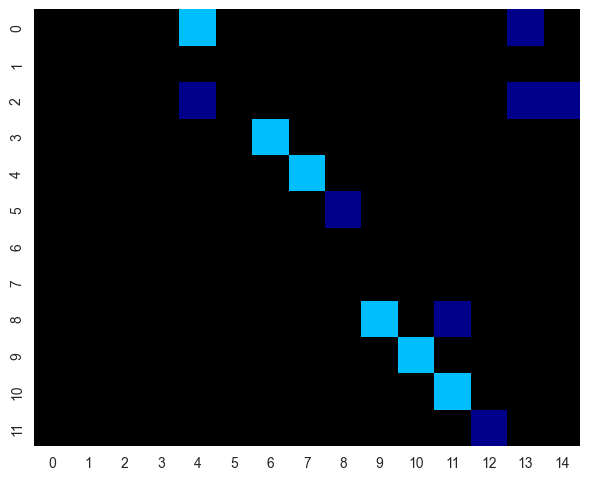

In [20]:
# only the abstract overlaps

text_fr, text_en = text_from_row(5607)
sentences_fr, sentences_en = create_sentences(text_fr, text_en)
similarity_matrix = create_similarity_matrix(sentences_fr, sentences_en, sentence_encoder)

plot_similarity_heatmap(similarity_matrix[:, 135:150], figsize=(6, 5))

### previous similarity matrix, including text cleaning prior to classification and correlation:
![](images/similarity_matrix_row_5607.png)

In [21]:
preview_publication_by_row(5607)

,5607
pub_number,RES 2016/066
text_fr,Cadre d'évaluation de la composante des reproducteurs d'automne du hareng de \nl'Atlantique (Clu...
text_en,Canadian Science Advisory Secretariat (CSAS). Assessment framework for fall-spawning Atlantic h...
len_fr,1864
len_en,73284
len_diff,39.3
len_min,1864
filename_fr,365980.pdf
filename_en,365980.pdf


,5680
pub_number,RES 2016/066
nom,Cadre d'évaluation de la composante des reproducteurs d'automne du hareng de l'Atlantique (Clupe...
name,Assessment framework for fall-spawning Atlantic herring (Clupea harengus) in the southern Gulf o...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2016/2016_066-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2016/2016_066-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/365980.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/365980.pdf


In [22]:
# with new sorting algorithm
threshold = 0.7
the_matrix, best_score, path = align_sentences(similarity_matrix, threshold=threshold)

print("Best total similarity:", best_score)
print("Number of matched pairs:", len(path))

Best total similarity: 7.2491436
Number of matched pairs: 9


In [23]:
[(y, x) for (x, y) in path]

[(139, 0),
 (141, 3),
 (142, 4),
 (168, 5),
 (181, 6),
 (310, 8),
 (423, 9),
 (427, 10),
 (428, 11)]

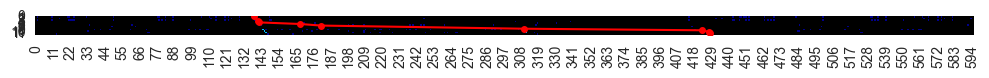

In [24]:
plot_similarity_heatmap(similarity_matrix, matched_pairs=[(y, x) for (x, y) in path])

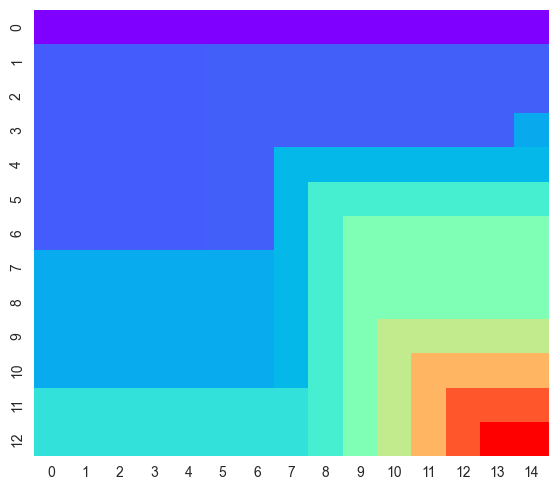

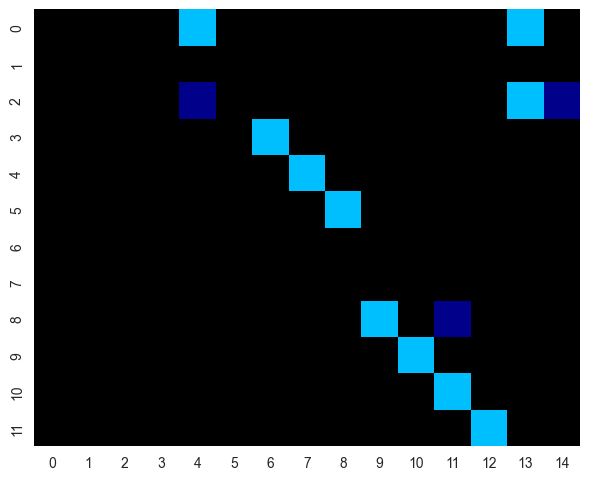

In [25]:
plot_similarity_heatmap(the_matrix[:, 135:150], cmap="rainbow", figsize=(6, 5))

plot_similarity_heatmap(
    similarity_matrix[:, 135:150], 
    low_similarity=0.6, 
    high_similarity=0.7, 
    figsize=(6, 5)
)

### previous results,  with text cleaning:

![](images/heatmap_path_full_row_5607.png)

![](images/heatmap_rainbox_row_5607.png)

![](images/similarity_matrix_row_5607_v2.png)

In [26]:
the_matrix, best_score, path = align_sentences(similarity_matrix, threshold=0.8)
[(y, x) for (x, y) in path]

[(139, 0), (141, 3), (142, 4), (144, 8), (145, 9), (146, 10)]

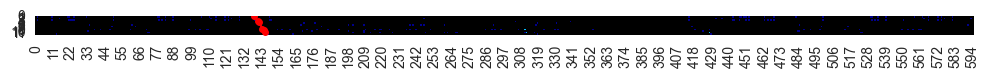

In [27]:
# looks way better with 0.8 threshold
plot_similarity_heatmap(similarity_matrix, matched_pairs=[(y, x) for (x, y) in path])

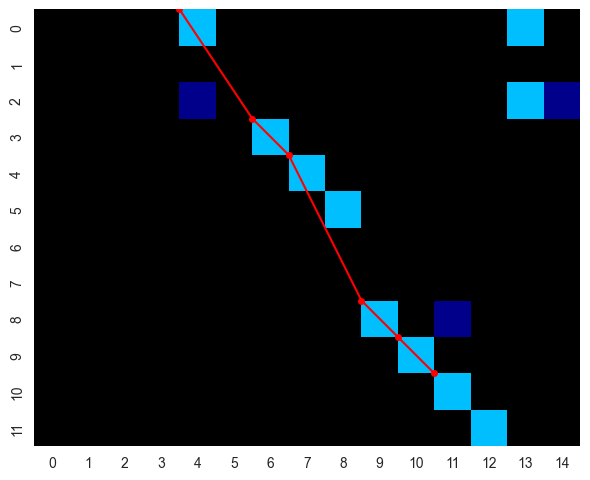

In [28]:
the_matrix, best_score, path = align_sentences(similarity_matrix, threshold=0.8)
plot_similarity_heatmap(
    similarity_matrix[:, 135:150], 
    low_similarity=0.6, 
    high_similarity=0.7, 
    figsize=(6, 5), 
    matched_pairs=[(y-135, x) for (x, y) in path]
)


### previous results,  with text cleaning:

![](images/similarity_matrix_path_row_5607_v2.png)

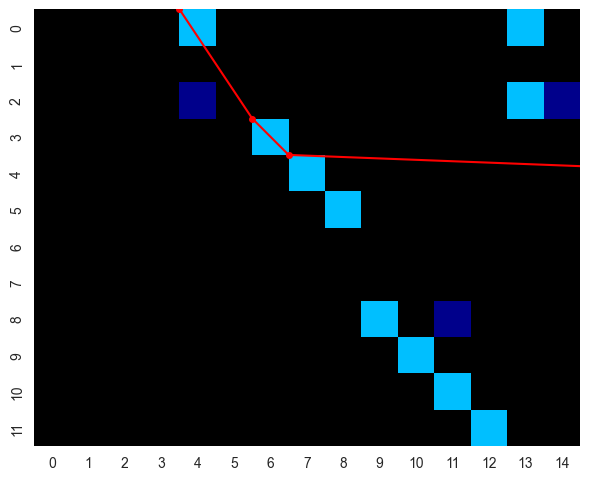

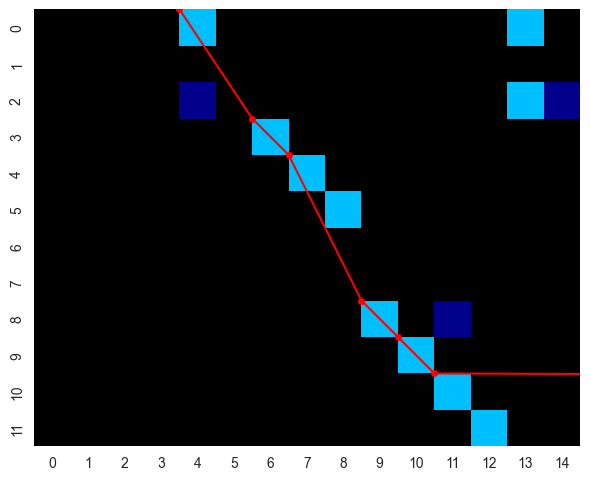

In [29]:
the_matrix, best_score, path = align_sentences(similarity_matrix, threshold=0.7)
plot_similarity_heatmap(
    similarity_matrix[:, 135:150], 
    low_similarity=0.6, 
    high_similarity=0.7, 
    figsize=(6, 5), 
    matched_pairs=[(y-135, x) for (x, y) in path]
)

the_matrix, best_score, path = align_sentences(similarity_matrix, threshold=0.75)
plot_similarity_heatmap(
    similarity_matrix[:, 135:150], 
    low_similarity=0.6, 
    high_similarity=0.7, 
    figsize=(6, 5), 
    matched_pairs=[(y-135, x) for (x, y) in path]
)

### previous results,  with text cleaning:

![](images/similarity_matrix_path_row_5607_v2_alt1.png)

![](images/similarity_matrix_path_row_5607_v2_alt2.png)

In [30]:
junk_df = matched_df.loc[(matched_df.len_fr < min_doc_chars) | (matched_df.len_en < min_doc_chars) | (matched_df.len_diff > max_len_ratio)].copy()
junk_pub_numbers = junk_df['pub_number'].to_list() 
junk_df.loc[:, 'year'] = junk_df['pub_number'].str.extract(r'(\d{4})')
junk_df['year'] = pd.to_numeric(junk_df['year'], errors='coerce')

good_df = fr_eng_correlation_df[(~fr_eng_correlation_df.pub_number.isin(junk_pub_numbers)) & (fr_eng_correlation_df.filename_fr != "WITHDRAWN")].copy()
good_df.loc[:, 'year'] = good_df['pub_number'].str.extract(r'(\d{4})')
good_df['year'] = pd.to_numeric(good_df['year'], errors='coerce')

In [31]:
# how many are single file en / fr? 
#  basically all of them

junk_filenames = fr_eng_correlation_df[fr_eng_correlation_df.pub_number.isin(junk_pub_numbers)]  # does not include withdrawn

(
    junk_filenames[junk_filenames.filename_en == junk_filenames.filename_fr].shape[0], 
    junk_filenames[junk_filenames.filename_en != junk_filenames.filename_fr].shape[0]
)

(4936, 8)

In [32]:
# nearly all fr text is lower, which is consistent with the abstract only translations
junk_df[junk_df.len_fr < junk_df.len_en].shape[0], junk_df[junk_df.len_fr > junk_df.len_en].shape[0]

(4673, 243)

In [33]:
# how many single file translations are good? 
#  542 vs 3522 double file translations

good_filenames = fr_eng_correlation_df[(~fr_eng_correlation_df.pub_number.isin(junk_pub_numbers)) & (fr_eng_correlation_df.filename_fr != "WITHDRAWN")]
(
    good_filenames[good_filenames.filename_fr == good_filenames.filename_en].shape[0],
    good_filenames[good_filenames.filename_fr != good_filenames.filename_en].shape[0],
)

(539, 3520)

In [34]:
# check len ratio and len min

def print_n_docs(char_n=None, len_ratio=None):
    if char_n:
        if len_ratio:
            print(matched_df.loc[(matched_df.len_fr < char_n) | (matched_df.len_en < char_n) | (matched_df.len_diff > len_ratio)].shape[0])
        else:
            print(matched_df.loc[(matched_df.len_fr < char_n) | (matched_df.len_en < char_n)].shape[0])
    elif len_ratio:
        print(matched_df.loc[matched_df.len_diff > len_ratio].shape[0])
    else:
        print(matched_df.shape[0])
    

In [35]:
print_n_docs(char_n=1000, len_ratio=5)
print_n_docs(char_n=1000)
print_n_docs(len_ratio=5)
print_n_docs(len_ratio=3)

4944
909
4923
5033


In [36]:
# let's look at len ratio between 3 and 5 - all look like only the abstract is translated
medium_filenames = matched_df.loc[(matched_df.len_diff >= 3) & (matched_df.len_diff < 5)].copy()

medium_pub_numbers = medium_filenames.pub_number.to_list()

medium_filenames.sample(10)

,pub_number,text_fr,text_en,len_fr,len_en,len_diff,len_min,filename_fr,filename_en
656,PRO 2011/064,Secrétariat canadien de consultation scientifique. Compte rendu 2011/064 \n \nRégion du Pacifiq...,Canadian Science Advisory Secretariat. Proceedings Series 2011/064 \n \nPacific Region. Region...,2914,14200,4.9,2914,345396.pdf,345396.pdf
1763,RES 1984/068,Ne pas citer sans\nautorisation des auteursl. Comite scientifique consultatif des\npeches canad...,Not to be cited without\npermission of the authors. Canadian Atlantic Fisheries\nScientific Adv...,811,2939,3.6,811,24146.pdf,24146.pdf
377,PRO 2006/036,Secrétariat canadien de consultation scientifique. Compte rendu de la réunion des experts \nsur...,Canadian Science Advisory Secretariat. Proceedings of the Expert Panel \nMeeting on the Potenti...,32075,121411,3.8,32075,327123.pdf,327123.pdf
2909,RES 1996/007,Ne pas citersans\nautorisation des auteurs '. MPO Pêchesde l'Atlantique\nDocument de recherche ...,Not to be cited without\npermission of the authors '. Incorporating Ecosystem Information into ...,3306,15400,4.7,3306,196654.pdf,196654.pdf
2963,RES 1996/061,Ne pas citer sans\nautorisation des auteurs'. MPO Pêches de l'Atlantique DFO Atlantic Fisheries...,Not to be cited without\npermission of the authors'. 'This series documents the scientific basi...,10579,2571,4.1,2571,198104.pdf,198104.pdf
2688,RES 1994/024,DFO Atlantic Fisheries MPO Pêches de l'Atlantique\nResearch Document 94/ 24 Document de recherch...,'This series documents the scientific basis\nfor the evaluation of fisheries resources in\nAtlan...,27374,8148,3.4,8148,168297.pdf,168297.pdf
2493,RES 1992/030,'Cette serie documente les bases \nscientifiques des oonseils de gestion \ndes peches sur la cOt...,"Department of Fisheries & oceans. Moncton, New Brunswick. ''1his series d~DD!mts the scientifi...",3569,17551,4.9,3569,136702.pdf,136702.pdf
1975,RES 1986/070,Ne pas citer sans\nautorisation des auteursl. Comite scientifique consultatif des\npeches canad...,Not to be cited without\npermission of the authorsl. Canadian Atlantic Fisheries\nScientific Ad...,1163,5608,4.8,1163,92671.pdf,92671.pdf
2074,RES 1987/050,Ne pas citer sans\nautorisation des auteurs'. Comite scientifique consultatif des\npeches canad...,Not to be cited without\npermission of the authorsi. Canadian Atlantic Fisheries\nScientific Ad...,948,3757,4.0,948,182527.pdf,182527.pdf
2241,RES 1989/034,Ne pas citer sans\nautorisation des auteurs'. Comite scientifique consultatif des\npeches canad...,Not to be cited without\npermission of the authors'. Canadian Atlantic Fisheries\nScientific Ad...,1038,4294,4.1,1038,111857.pdf,111857.pdf


In [37]:
# only abstract translated (short body): 4986, 2879, 3728
preview_publication(random.choice(medium_pub_numbers))

,3878
pub_number,RES 2001/103
nom,Conversion de données sur le sébaste de la sous-zone 2 et de la division 3K issues de relevés de...
name,Canadian Research Survey Data Conversions for Redfish in SA2 + Div. 3K based on Comparative Fish...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2001/2001_103-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2001/2001_103-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/266885.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/266885.pdf


In [38]:
# what about a ratio of 2? -> only 22 more beyond what is already in 3
print_n_docs(len_ratio=2)

5047


In [39]:
medium_filenames = matched_df.loc[(matched_df.len_diff >= 2) & (matched_df.len_diff < 3)].copy()
medium_pub_numbers = medium_filenames.pub_number.to_list()
medium_filenames.drop(['text_fr', 'text_en'], axis=1)

,pub_number,len_fr,len_en,len_diff,len_min,filename_fr,filename_en
238,PRO 2003/038,10559,28872,2.7,10559,277995.pdf,277995.pdf
287,PRO 2004/010,92931,187667,2.0,92931,282946.pdf,282946.pdf
400,PRO 2007/011,2262,6762,3.0,2262,328381.pdf,328381.pdf
1630,RES 1983/024,928,2602,2.8,928,38999.pdf,38999.pdf
2520,RES 1992/057,16365,5556,2.9,5556,139073.pdf,139073.pdf
2746,RES 1994/082,17903,6596,2.7,6596,179482.pdf,179482.pdf
2760,RES 1994/096,7615,19245,2.5,7615,180433.pdf,180433.pdf
2955,RES 1996/053,28081,9461,3.0,9461,198102.pdf,198102.pdf
3596,RES 2000/041,31151,65778,2.1,31151,265909.pdf,248180.pdf
4310,RES 2005/088,13476,34796,2.6,13476,321068.pdf,321068.pdf


In [40]:
# with matching filenames
#  only partially translated: a bit more complicated than the abstract only (forward, attached letter, etc)
weblinks_df.loc[weblinks_df.pub_number.isin(medium_pub_numbers) & (weblinks_df.file_url_fr == weblinks_df.file_url_en), ['pub_number', 'file_url_fr', 'file_url_en']]

,pub_number,file_url_fr,file_url_en
246,PRO 2003/038,http://waves-vagues.dfo-mpo.gc.ca/Library/277995.pdf,http://waves-vagues.dfo-mpo.gc.ca/Library/277995.pdf
295,PRO 2004/010,http://waves-vagues.dfo-mpo.gc.ca/Library/282946.pdf,http://waves-vagues.dfo-mpo.gc.ca/Library/282946.pdf
412,PRO 2007/011,http://waves-vagues.dfo-mpo.gc.ca/Library/328381.pdf,http://waves-vagues.dfo-mpo.gc.ca/Library/328381.pdf
1658,RES 1983/024,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/38999.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/38999.pdf
2548,RES 1992/057,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/139073.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/139073.pdf
2774,RES 1994/082,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/179482.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/179482.pdf
2788,RES 1994/096,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/180433.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/180433.pdf
2983,RES 1996/053,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/198102.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/198102.pdf
4379,RES 2005/088,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/321068.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/321068.pdf


In [41]:
# with different files 
#  these may all be errors (every one I checked was a website linking error)
weblinks_df.loc[weblinks_df.pub_number.isin(medium_pub_numbers) & (weblinks_df.file_url_fr != weblinks_df.file_url_en), ['pub_number', 'file_url_fr', 'file_url_en']]

,pub_number,file_url_fr,file_url_en
3642,RES 2000/041,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/265909.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/248180.pdf
6922,SAR 2012/045,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348373.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348324.pdf
7761,SCR 2012/041,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347658.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347657.pdf
7839,SCR 2014/033,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/363608.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/363607.pdf


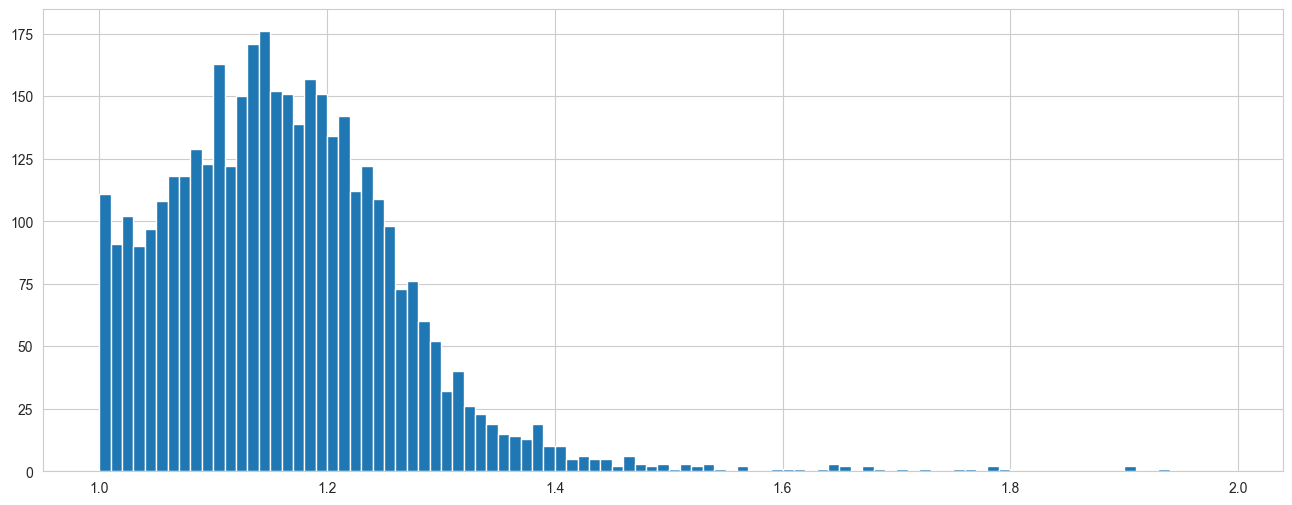

In [42]:
# let's make a histogram for len_diff, and try to guess where the good data starts
matched_df.len_diff.hist(bins=[x/100 for x in range(100, 200)], figsize=(16, 6));

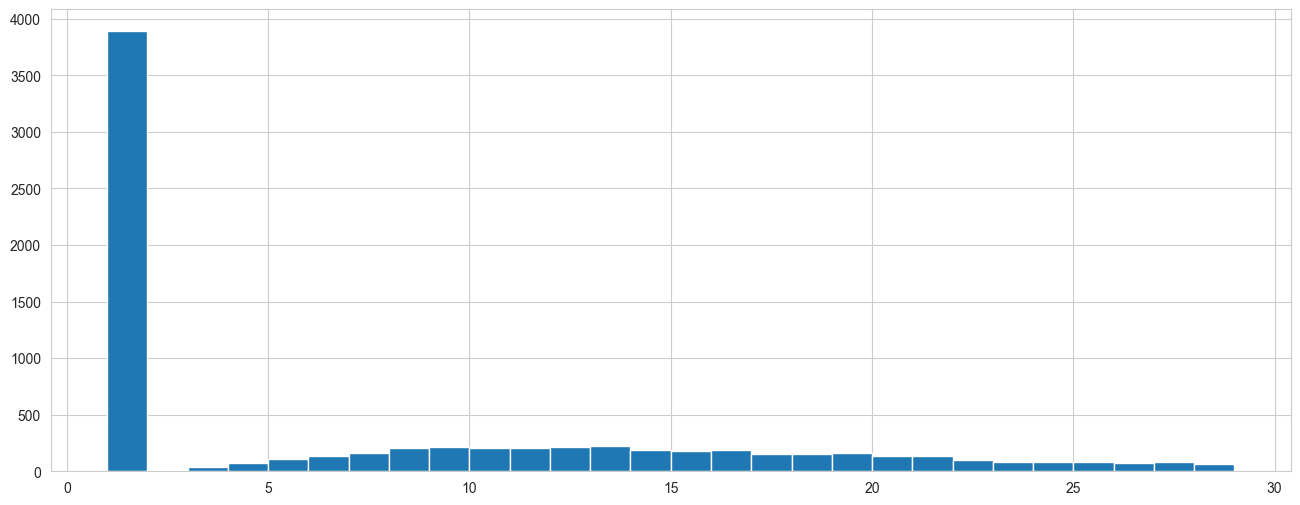

In [43]:
matched_df.len_diff.hist(bins=[x for x in range(1, 30, 1)], figsize=(16, 6));

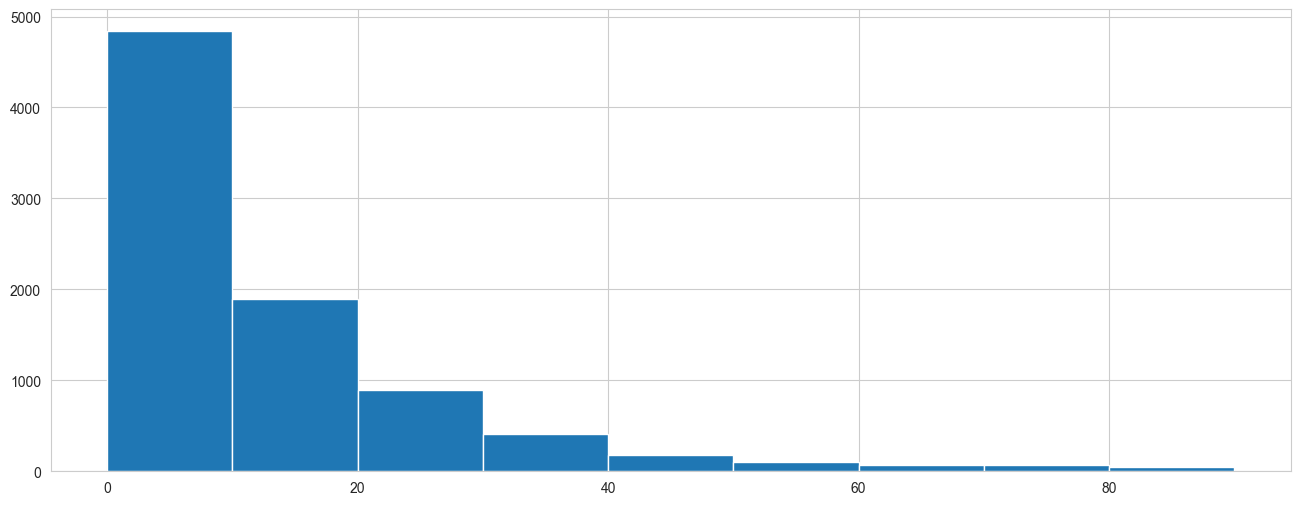

In [44]:
matched_df.len_diff.hist(bins=[x for x in range(0, 100, 10)], figsize=(16, 6));

### previous results:

![](images/hist_2.png)

![](images/hist_30.png)

![](images/hist_100.png)

In [45]:
max_ratio = 2

junk_min = matched_df.loc[matched_df.len_diff > max_ratio, 'len_min'].sum()
all_min = matched_df['len_min'].sum()

f'Potentially usable text outside the max ratio ({max_ratio}:1) = {junk_min/all_min:.1%}'

'Potentially usable text outside the max ratio (2:1) = 6.2%'

# ERRORS IN DATA

In [46]:
# this is just wrong - the french link is SAR 2012/031, not PRO 2012/031 - these really should have different numbers 
#  https://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2012/2012_031-fra.html
# preview_publication('PRO 2012/031')

In [47]:
# also wrong - the french link is wrong on the website
#  https://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2000/2000_041-fra.htm
# preview_publication("RES 2000/041")

In [48]:
# the first 3 I checked had incorrect french links on the website - I assume all of these are bad data
for pub in weblinks_df[weblinks_df.pub_number.isin(medium_pub_numbers) & (weblinks_df.file_url_fr != weblinks_df.file_url_en)].pub_number.to_list():
    preview_publication(pub)

,3642
pub_number,RES 2000/041
nom,NaN
name,"Status of Atlantic salmon (Salmo salar L.) In Indian bay Brook, Middle Brook, and Terra Nova Riv..."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2000/2000_041-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2000/2000_041-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/265909.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/248180.pdf


,6922
pub_number,SAR 2012/045
nom,"Évaluation de l'inconnu (Stenodus leucichthys) de la rivière Buffalo, Grand lac des Esclaves, Te..."
name,"Assessment of Buffalo River Inconnu (Stenodus leucichthys) Great Slave Lake, Northwest Territori..."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2012/2012_045-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2012/2012_045-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348373.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348324.pdf


,7761
pub_number,SCR 2012/041
nom,Probabilité que les stocks de crevette tachetée (Pandalus platyceros) se trouvant dans les zones...
name,Probability of spot prawn (Pandalus platyceros) stocks in fall survey areas in British Columbia ...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2012/2012_041-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2012/2012_041-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347658.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347657.pdf


,7839
pub_number,SCR 2014/033
nom,Évaluation de la possibilité de rouvrir les zones de fermeture A et B du Grand Lac des esclaves
name,Assessment of the potential to re-open Great Slave Lake Closure Zones A and B
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/scr-rs/2014/2014_033-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2014/2014_033-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/363608.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/363607.pdf


In [49]:
# what about all messed up len ratio with different files? 
#  mostly website errors
#  some same file copied to 2 filenames, only summary translated
bad_pub_numbers = matched_df.loc[(matched_df.len_diff > 2)].pub_number.to_list()
weblinks_df.loc[weblinks_df.pub_number.isin(bad_pub_numbers) & (weblinks_df.file_url_fr != weblinks_df.file_url_en), ['pub_number', 'url_fr', 'url_en', 'file_url_fr', 'file_url_en']]

,pub_number,url_fr,url_en,file_url_fr,file_url_en
737,PRO 2012/059,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2012/2012_059-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2012/2012_059-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348617.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348616.pdf
3642,RES 2000/041,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2000/2000_041-fra.htm,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2000/2000_041-eng.htm,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/265909.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/248180.pdf
5275,RES 2013/002,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2013/2013_002-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2013/2013_002-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348703.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348701.pdf
6017,RES 2020/066,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2020/2020_066-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2020/2020_066-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/40953348.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/40953324.pdf
6212,RES 2023/026,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2023/2023_026-fra.html,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2023/2023_026-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41117748.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41117554.pdf
6767,SAR 2010/070,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2010/2010_070-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2010/2010_070-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/343603.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/343602.pdf
6843,SAR 2011/067,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2011/2011_067-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2011/2011_067-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/346314.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/346313.pdf
6922,SAR 2012/045,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2012/2012_045-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2012/2012_045-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348373.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348324.pdf
7062,SAR 2014/042,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2014/2014_042-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2014/2014_042-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/352153.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/364309.pdf
7761,SCR 2012/041,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2012/2012_041-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2012/2012_041-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347658.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347657.pdf


In [50]:
# different file link, but identical file - only summary translated 
matched_df[matched_df.pub_number == 'PRO 2012/059'].T

,725
pub_number,PRO 2012/059
text_fr,"du MPO, Compte rendu 2012/059. rostriformis bugenis), qui sont toutes \ndeux originaires de la ..."
text_en,Canadian Science Advisory Secretariat (CSAS). Proceedings Series 2012/059. National Capital Re...
len_fr,1809
len_en,33694
len_diff,18.6
len_min,1809
filename_fr,348617.pdf
filename_en,348616.pdf


In [51]:
# is correct? (yes)
preview_publication("RES 2018/029")
matched_df[matched_df.pub_number == 'RES 2018/029'].T

,5851
pub_number,RES 2018/029
nom,"Abondance de la population, caractéristiques biologiques et contribution aux pêches côtières de ..."
name,"Population abundance, biological characteristics, and contribution to coastal mixed-stock fisher..."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2018/2018_029-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2018/2018_029-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/40759489.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/40759453.pdf


,5777
pub_number,RES 2018/029
text_fr,"Secrétariat canadien de consultation scientifique. Abondance de la population, caractéristiques..."
text_en,Canadian Science Advisory Secretariat (CSAS). Research Document 2018/029 \nCentral and Arctic R...
len_fr,78611
len_en,81557
len_diff,1.0
len_min,78611
filename_fr,40759489.pdf
filename_en,40759453.pdf


# NOT ERROR ANYMORE: pathfinding algorithm showcase

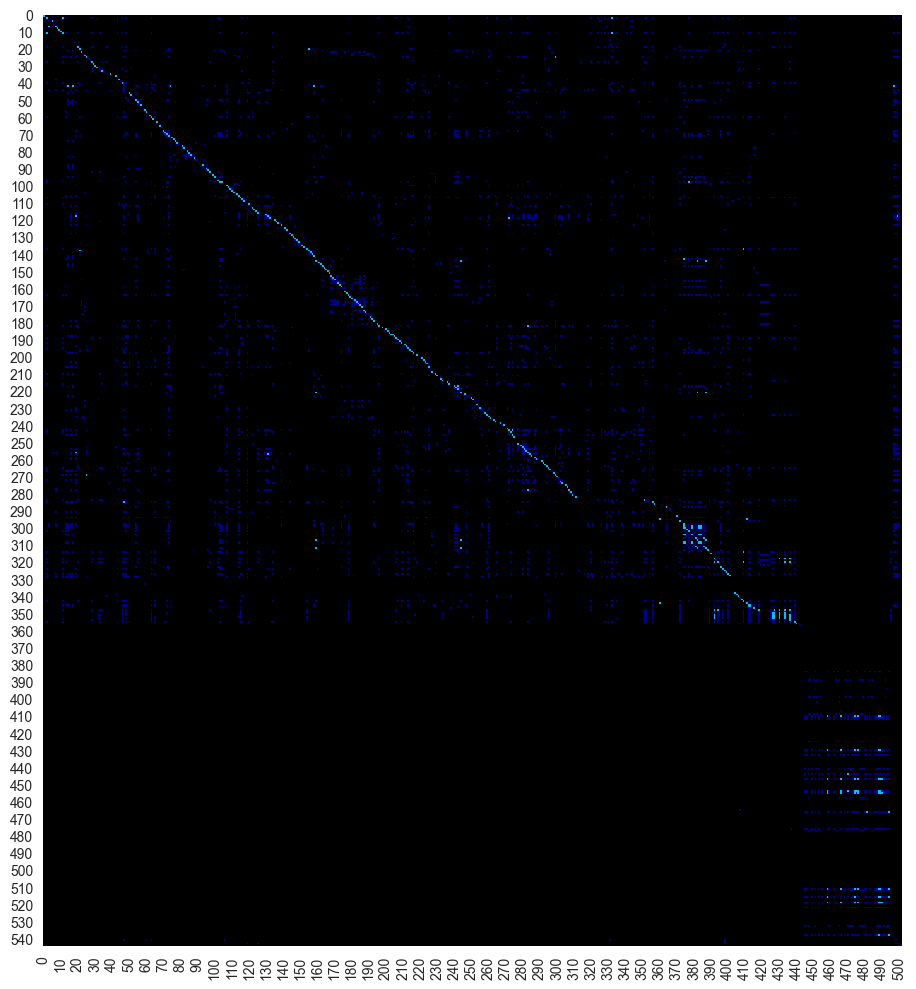

In [52]:
# NOTE: 'RES 2018/029' is now fixed with new min/max block sizes

# old notes:
# way more en than fr but actually matches
#  looks like a bunch of tables only got translated to english, wrecking the char ratio, even thoug the chunk ratio is less than 2
pub_number = 'RES 2018/029'
text_fr, text_en = text_from_pub_number(pub_number)
sentences_fr, sentences_en = create_sentences(text_fr, text_en)
similarity_matrix_5851 = create_similarity_matrix(sentences_fr, sentences_en, sentence_encoder)
plot_similarity_heatmap(similarity_matrix_5851)

# previous:
![](images/heatmap_5851_default.png)

In [53]:
# sentences_en[450:500]

In [54]:
threshold = 0.7
the_matrix, best_score, path = align_sentences(similarity_matrix_5851, threshold=threshold)

print("Best total similarity:", best_score)
print("Number of matched pairs:", len(path))

Best total similarity: 267.02084
Number of matched pairs: 307


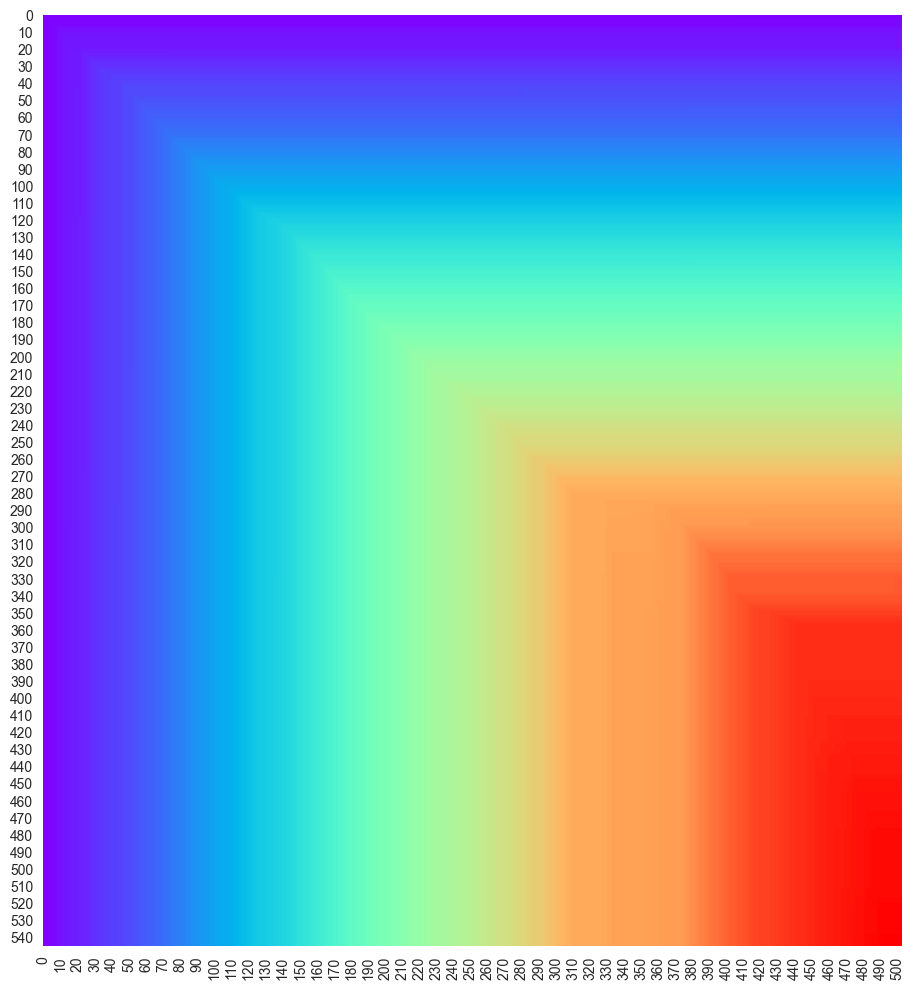

In [55]:
plot_similarity_heatmap(the_matrix, cmap="rainbow")

# previous:
![](images/rainbow_5851.png)

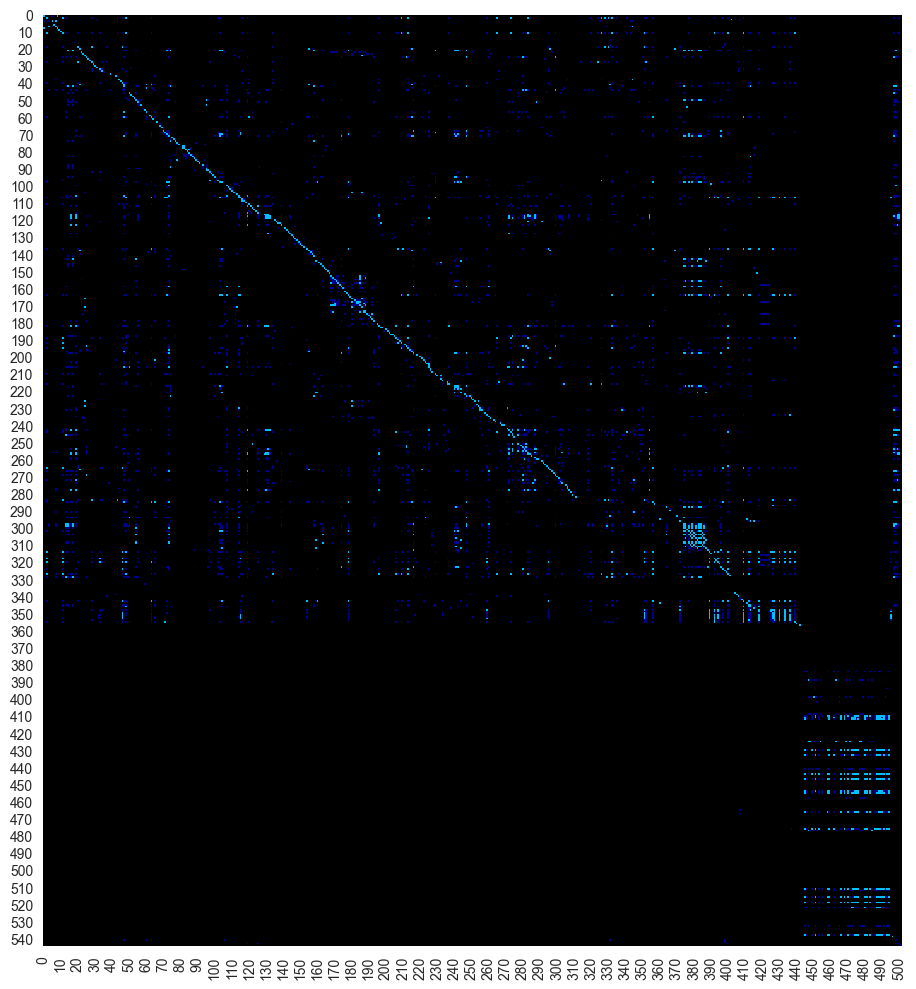

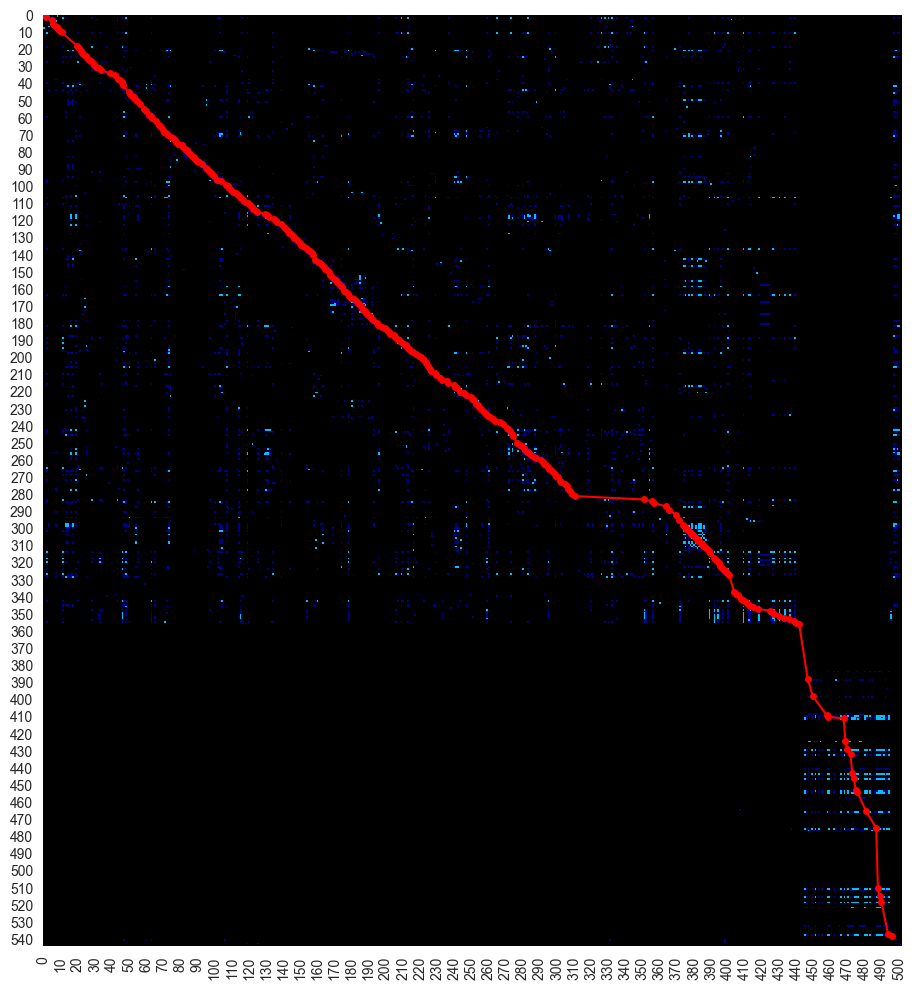

In [56]:
plot_similarity_heatmap(
    similarity_matrix_5851, 
    low_similarity=0.6, 
    high_similarity=0.7, 
)

plot_similarity_heatmap(
    similarity_matrix_5851, 
    low_similarity=0.6, 
    high_similarity=0.7, 
    matched_pairs=[(y, x) for (x, y) in path]
)

### previous:

![](images/heatmap_5851.png)

![](images/heatmap_path_5851.png)

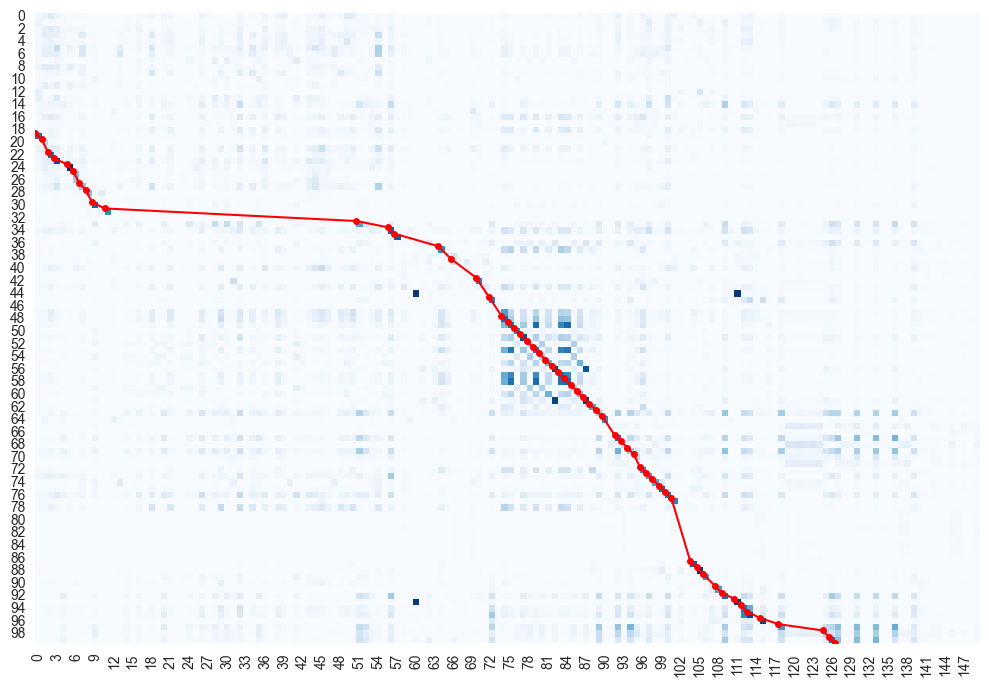

In [57]:
plot_similarity_heatmap(similarity_matrix_5851[250:350, 300:450]**5, cmap="Blues", 
    matched_pairs=[(y-300, x-250) for (x, y) in path])

# previous:
![](images/path_details_5851.png)

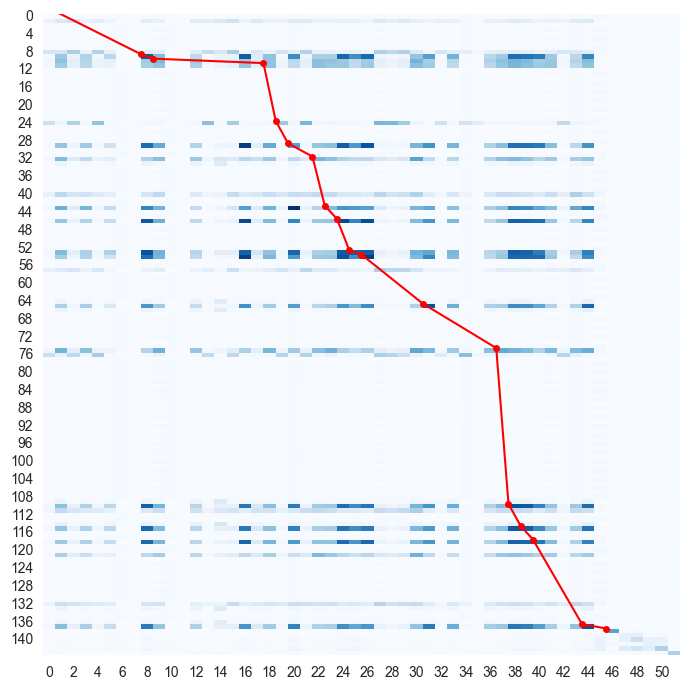

In [58]:
plot_similarity_heatmap(similarity_matrix_5851[400:, 450:]**5, cmap="Blues", 
    matched_pairs=[(y-450, x-400) for (x, y) in path], figsize=(7, 7), square=False)

In [65]:
# the last 17 sentences are the most appendixy of all - they actually look pretty good, 
#  TODO: some mismatches, not sure if this will affect finetuning

for (_, x, y) in text_from_coordinates(path[-20:], sentences_fr, sentences_en, pub_number):
    print(clean_text(x))
    print(clean_text(y))
    print()


Il est bon de noter qu on a confirmé d une femelle de 370 mm en condition de frai (21 septembre 2012 dans la senne 3) était à un cycle biologique de résidente grâce à une analyse de strontium otolithe
It is noted that a 370 mm female in spawning condition (September 21, 2012 in seine 3) was confirmed to be a resident life history using otolith strontium analysis

Anadromes 19-Sep-10 5 490 Femelle Géniteurs 123 cicatrice Postérieur Ventral Rouge zone 1
Anadromous 19-Sep-10 5 490 Female Spawner 123 scar Posterior ventral Red Zone 1

Anadromes 24-Sep-10 10 710 Mâle Géniteurs 273 blessure Antérieur Dorsal Rouge zone 1
Anadromous 24-Sep-10 10 710 Male Spawner 273 wound Anterior dorsal Red Zone 1

Resident 26-Sep-10 16 165 Mâle Géniteurs zone 2 Résident 26-Sep-10 16 235 Mâle Géniteurs zone 2 Résident 26-Sep-10 16 245 Mâle Géniteurs zone 2 Résident 26-Sep-10 16 260 Mâle Géniteurs zone 2
area Resident 26-Sep-10 16 235 Male Spawner Zone 2 Resident 26-Sep-10 16 245 Male Spawner Zone 2 Resident 2

In [64]:
for (_, x, y) in text_from_coordinates(random.sample(path, 10), sentences_fr, sentences_en, pub_number):
    print(clean_text(x))
    print(clean_text(y))
    print()

Résident 25-Sep-14 8 170 Mâle Géniteurs zone 2 Résident 25-Sep-14 8 265 Mâle Géniteurs zone 2 Résident 25-Sep-14 8 195 Mâle Géniteurs zone 2 Résident 25-Sep-14 8 220 Mâle Géniteurs zone 2 Résident 25-Sep-14 8 170 Mâle Géniteurs zone 2
Resident 25-Sep-14 8 170 Male Spawner Zone 2 Resident 25-Sep-14 8 265 Male Spawner Zone 2 Resident 25-Sep-14 8 195 Male Spawner Zone 2 Resident 25-Sep-14 8 220 Male Spawner Zone 2 Resident 25-Sep-14 8 170 Male Spawner Zone 2

Distribution de la fréquence de longueur des poissons remontant et descendant la rivière Babbage observés à l aide d une caméra DIDSON en 2011 et nombre de Dolly Varden capturés à l aide d une fascine déployée dans la rivière en 1990, 1991 et 1992
Length frequency distribution of fish moving upstream and downstream in the Babbage River observed using the DIDSON camera in 2011, and of Dolly Varden captured using a weir deployed in the river in 1990, 1991 and 1992

Longueurs à la fourche (médianes, quartiles et valeurs aberrantes , ; v